# Data Preprocessing and Feature Engineering

The objective of this notebook is to clean and transform the student performance dataset for modeling. 

Contents:
1. Load data and remove duplicates
2. Create binary target variable
3. Feature engineering
4. Encode categorical features
5. Scale numerical features
6. Train/test split
7. Save preprocessed datasets

## Setup and Load Data

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sys
import os

# Import the scripts path
sys.path.append('../scripts')
import misc

In [5]:
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [7]:
# Define project paths
ROOT = Path.cwd().parent if (Path.cwd().parent / 'data').exists() else Path.cwd()

# Call the relevant paths
DATA_RAW, DATA_PROC, FIGS = misc.get_relevant_paths(ROOT)

Project Root: /home/row/Desktop/projects/MLOps-Phase2
Raw Data: /home/row/Desktop/projects/MLOps-Phase2/data/raw
Processed Data: /home/row/Desktop/projects/MLOps-Phase2/data/processed
Figures: /home/row/Desktop/projects/MLOps-Phase2/reports/figures


In [10]:
# Load the dataset from EDA notebook
dataset_path = os.path.join(DATA_PROC, 'student_entry_performance_eda.csv') 
df = pd.read_csv(dataset_path)

misc.describe_dataframe(df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/row/Desktop/projects/MLOps-Phase2/data/processed/student_entry_performance_eda.csv'

## Remove Duplicates

In [4]:
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Remove duplicates
df_clean = df.drop_duplicates()

print(f"After removing duplicates: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")
print(f"Percentage removed: {((df.shape[0] - df_clean.shape[0]) / df.shape[0] * 100):.2f}%")

# Verify no missing values
print(f"\nMissing values check:")
print(df_clean.isnull().sum().sum())
print("✓ No missing values" if df_clean.isnull().sum().sum() == 0 else "Missing values found")


Original dataset shape: (666, 12)
Number of duplicate rows: 44
After removing duplicates: (622, 12)
Rows removed: 44
Percentage removed: 6.61%

Missing values check:
0
✓ No missing values


## Create Binary Target Variable

In [6]:
# Original Performance distribution
print("\nOriginal Performance Distribution:")
print(df_clean['Performance'].value_counts())
print("\nPercentages:")
print(df_clean['Performance'].value_counts(normalize=True).mul(100).round(2))

# Create bianry target varibale
def create_binary_target(performance):
    """
    Convert 4-class performance to binary
    - Excellent, Vg  → 1 (High Performance)
    - Good, Average → 0 (Lower Performance)
    """
    if performance in ['Excellent', 'Vg']:
        return 1 # High performance
    else:
        return 0 # Lower performance
    
df_clean['Performance_Binary'] = df_clean['Performance'].apply(create_binary_target)

# Check binary distribution
print(f"\n{'='*80}")
print("Binary Performance Distribution:")
print(f"{'='*80}")
print(df_clean['Performance_Binary'].value_counts())
print("\nClass Balance:")
balance = df_clean['Performance_Binary'].value_counts(normalize=True).mul(100).round(2)
print(balance)

print(f"\nClass 0 (Lower Performance): {balance[0]}%")
print(f"Class 1 (High Performance): {balance[1]}%")
print(f"Balance Ratio: {balance[0]/balance[1]:.2f}:1")


Original Performance Distribution:
Performance
Good         194
Vg           178
Average      152
Excellent     98
Name: count, dtype: int64

Percentages:
Performance
Good         31.19
Vg           28.62
Average      24.44
Excellent    15.76
Name: proportion, dtype: float64

Binary Performance Distribution:
Performance_Binary
0    346
1    276
Name: count, dtype: int64

Class Balance:
Performance_Binary
0    55.63
1    44.37
Name: proportion, dtype: float64

Class 0 (Lower Performance): 55.63%
Class 1 (High Performance): 44.37%
Balance Ratio: 1.25:1



Saved figure to: /Users/lia/Desktop/Fase1/reports/figures/binary_target_distribution_20251023_103537.png


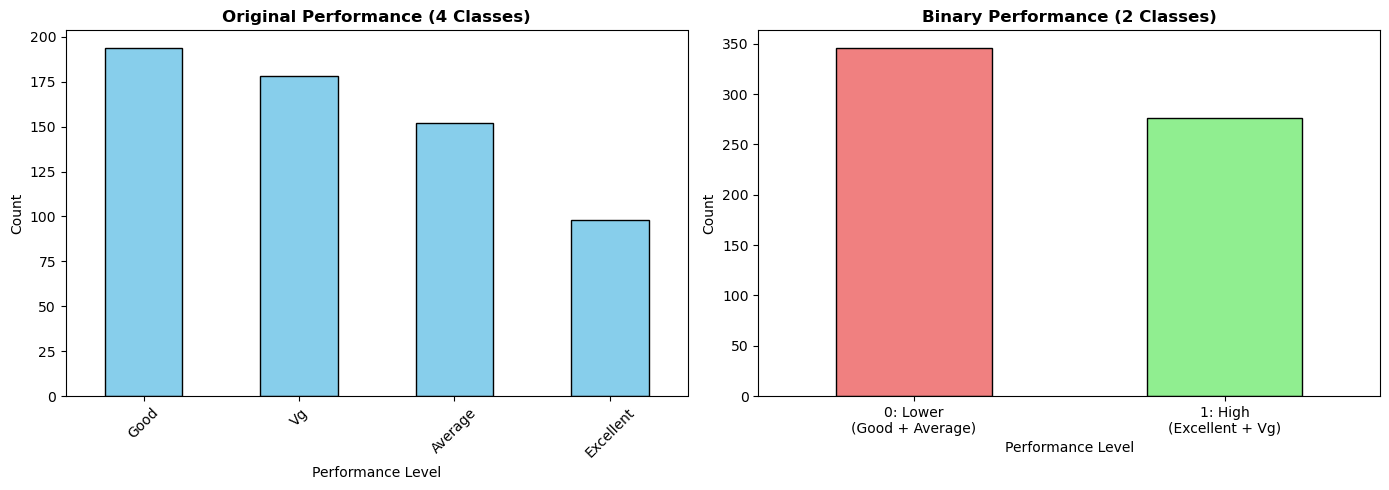


Cleaned dataset saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_cleaned.csv


In [8]:
# Visualize binary target distribution
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Original Performance
df_clean['Performance'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Original Performance (4 Classes)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Performance Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Binary Performance
df_clean['Performance_Binary'].value_counts().sort_index().plot(kind='bar', ax=axes[1], 
                                                                 color=['lightcoral', 'lightgreen'], 
                                                                 edgecolor='black')
axes[1].set_title('Binary Performance (2 Classes)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Performance Level')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['0: Lower\n(Good + Average)', '1: High\n(Excellent + Vg)'], rotation=0)

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"binary_target_distribution_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\nSaved figure to: {out_path}")

plt.show()

# Save cleaned dataset with binary target
output_path = DATA_PROC / "student_performance_cleaned.csv"
df_clean.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved to: {output_path}")


## Feature Engineering

In [10]:
# Create a copy for feature engineering
df_processed = df_clean.copy()

# Group rare study time categories
print('\nOriginal study time distribution:')
print(df_processed['time'].value_counts())

def group_study_time(time_val):
    """
    Group rare study time categories: 
    - FOUR, FIVE, SEVEN → FOUR_PLUS
    - ONE, TWO, THREE → Keep as is
    """
    if time_val in ['FOUR', 'FIVE', 'SEVEN']:
        return 'FOUR_PLUS'
    else:
        return time_val
    
df_processed['time'] = df_processed['time'].apply(group_study_time)

print("\nAfter grouping rare categories:")
print(df_processed['time'].value_counts())
print("✓ Rare categories combined successfully")


Original study time distribution:
time
TWO      339
ONE      185
THREE     85
FOUR      11
FIVE       1
SEVEN      1
Name: count, dtype: int64

After grouping rare categories:
time
TWO          339
ONE          185
THREE         85
FOUR_PLUS     13
Name: count, dtype: int64
✓ Rare categories combined successfully


## Encode Categorical Features

In [11]:
# Define ordinal mappings
grade_mapping = {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}
time_mapping = {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR_PLUS': 4}

print("\nOrdinal Encoding Mappings:")
print(f"Grades: {grade_mapping}")
print(f"Time: {time_mapping}")

# Apply ordinal encoding
df_processed['Class_X_Grade_Encoded'] = df_processed['Class_X_Percentage'].map(grade_mapping)
df_processed['Class_XII_Grade_Encoded'] = df_processed['Class_XII_Percentage'].map(grade_mapping)
df_processed['Study_Time_Encoded'] = df_processed['time'].map(time_mapping)

print("\nOrdinal encoding applied to:")
print("- Class_X_Percentage → Class_X_Grade_Encoded")
print("- Class_XII_Percentage → Class_XII_Grade_Encoded")
print("- time → Study_Time_Encoded")

# Define columns for one-hot encoding
nominal_columns = ['Gender', 'Caste', 'coaching', 'Class_ten_education',
                   'twelve_education', 'medium', 'Father_occupation', 'Mother_occupation']

print(f"\nNominal columns for one-hot encoding: {len(nominal_columns)}")
for col in nominal_columns:
    print(f"  - {col}: {df_processed[col].nunique()} unique values")

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=nominal_columns, drop_first=True)

print(f"\n✓ One-hot encoding complete")
print(f"Dataset shape after encoding: {df_encoded.shape}")

# Show sample of encoded columns
print("\nSample of encoded feature columns:")
encoded_cols = [col for col in df_encoded.columns if any(x in col for x in nominal_columns)]
for i, col in enumerate(encoded_cols[:15], 1):
    print(f"  {i:2d}. {col}")
if len(encoded_cols) > 15:
    print(f"  ... and {len(encoded_cols)-15} more")


Ordinal Encoding Mappings:
Grades: {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}
Time: {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR_PLUS': 4}

Ordinal encoding applied to:
- Class_X_Percentage → Class_X_Grade_Encoded
- Class_XII_Percentage → Class_XII_Grade_Encoded
- time → Study_Time_Encoded

Nominal columns for one-hot encoding: 8
  - Gender: 2 unique values
  - Caste: 4 unique values
  - coaching: 3 unique values
  - Class_ten_education: 3 unique values
  - twelve_education: 3 unique values
  - medium: 3 unique values
  - Father_occupation: 8 unique values
  - Mother_occupation: 9 unique values

✓ One-hot encoding complete
Dataset shape after encoding: (622, 35)

Sample of encoded feature columns:
   1. Gender_male
   2. Caste_OBC
   3. Caste_SC
   4. Caste_ST
   5. coaching_OA
   6. coaching_WA
   7. Class_ten_education_OTHERS
   8. Class_ten_education_SEBA
   9. twelve_education_CBSE
  10. twelve_education_OTHERS
  11. medium_ENGLISH
  12. medium_OTHERS
  13. Father_occupation_BUS

## Select Featires and Prepare for Modeling

In [13]:
# Select features for modeling (exclude original categorical and target columns)
feature_columns = [col for col in df_encoded.columns if col not in
                   ['Performance', 'Performance_Binary', 'Class_X_Percentage', 
                    'Class_XII_Percentage', 'time']]

X = df_encoded[feature_columns]
y = df_encoded['Performance_Binary']

print(f'\nFeature matrix shape: {X.shape}')
print(f'Target vector shape: {y.shape}')
print(f'Number of features: {X.shape[1]}')

# Display all feature names
print(f"\n{'='*80}")
print("ALL FEATURES BEING USED FOR MODELING:")
print(f"{'='*80}")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")


Feature matrix shape: (622, 30)
Target vector shape: (622,)
Number of features: 30

ALL FEATURES BEING USED FOR MODELING:
 1. Class_X_Grade_Encoded
 2. Class_XII_Grade_Encoded
 3. Study_Time_Encoded
 4. Gender_male
 5. Caste_OBC
 6. Caste_SC
 7. Caste_ST
 8. coaching_OA
 9. coaching_WA
10. Class_ten_education_OTHERS
11. Class_ten_education_SEBA
12. twelve_education_CBSE
13. twelve_education_OTHERS
14. medium_ENGLISH
15. medium_OTHERS
16. Father_occupation_BUSINESS
17. Father_occupation_COLLEGE_TEACHER
18. Father_occupation_CULTIVATOR
19. Father_occupation_DOCTOR
20. Father_occupation_ENGINEER
21. Father_occupation_OTHERS
22. Father_occupation_SCHOOL_TEACHER
23. Mother_occupation_BUSINESS
24. Mother_occupation_COLLEGE_TEACHER
25. Mother_occupation_CULTIVATOR
26. Mother_occupation_DOCTOR
27. Mother_occupation_ENGINEER
28. Mother_occupation_HOUSE_WIFE
29. Mother_occupation_OTHERS
30. Mother_occupation_SCHOOL_TEACHER


## Scale Numerical Features

In [14]:
# Separate ordinal features for scaling
ordinal_features = ['Class_X_Grade_Encoded', 'Class_XII_Grade_Encoded', 'Study_Time_Encoded']
binary_features = [col for col in X.columns if col not in ordinal_features]

print(f"\nOrdinal features to scale: {len(ordinal_features)}")
for feat in ordinal_features:
    print(f"  - {feat}")

print(f"\nBinary features (already 0/1): {len(binary_features)}")
print("  (Not scaling binary features - they're already normalized)")


Ordinal features to scale: 3
  - Class_X_Grade_Encoded
  - Class_XII_Grade_Encoded
  - Study_Time_Encoded

Binary features (already 0/1): 27
  (Not scaling binary features - they're already normalized)


In [15]:
# Initialize scaler
scaler = StandardScaler()

# Create copy for scaled data
X_scaled = X.copy()

# Scale only ordinal features
X_scaled[ordinal_features] = scaler.fit_transform(X[ordinal_features])

print('\nStandardScaler applied to ordinal features')

print("\nScaling parameters:")
for i, feat in enumerate(ordinal_features):
    print(f"  {feat}:")
    print(f"    Mean: {scaler.mean_[i]:.3f}")
    print(f"    Std:  {scaler.scale_[i]:.3f}")


StandardScaler applied to ordinal features

Scaling parameters:
  Class_X_Grade_Encoded:
    Mean: 3.648
    Std:  0.694
  Class_XII_Grade_Encoded:
    Mean: 3.424
    Std:  0.773
  Study_Time_Encoded:
    Mean: 1.881
    Std:  0.710


In [16]:
# Show before/after example
print(f"\n{'='*80}")
print("First 5 rows before and after scaling")
print(f"{'='*80}")

print("\nBefore scaling (ordinal features):")
print(X[ordinal_features].head())

print("\nAfter scaling (ordinal features):")
print(X_scaled[ordinal_features].head())


First 5 rows before and after scaling

Before scaling (ordinal features):
   Class_X_Grade_Encoded  Class_XII_Grade_Encoded  Study_Time_Encoded
0                      4                        4                   1
1                      4                        4                   2
2                      4                        4                   2
3                      4                        4                   1
4                      4                        4                   2

After scaling (ordinal features):
   Class_X_Grade_Encoded  Class_XII_Grade_Encoded  Study_Time_Encoded
0               0.507068                 0.744297           -1.241587
1               0.507068                 0.744297            0.167660
2               0.507068                 0.744297            0.167660
3               0.507068                 0.744297           -1.241587
4               0.507068                 0.744297            0.167660



Saved scaling visualization to: /Users/lia/Desktop/Fase1/reports/figures/feature_scaling_effect_20251023_104734.png


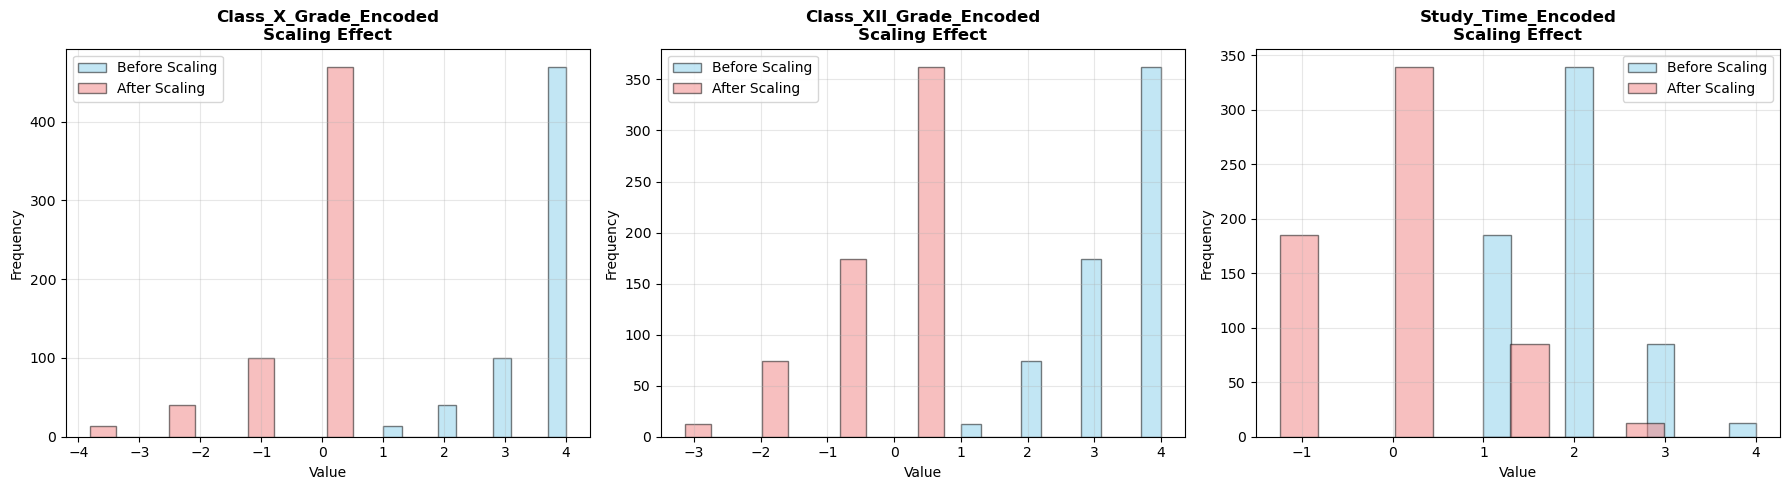

In [17]:
# Visualize scaling effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feat in enumerate(ordinal_features):
    # Before scaling
    X[feat].hist(ax=axes[i], bins=10, alpha=0.5, label='Before Scaling', color='skyblue', edgecolor='black')
    # After scaling
    X_scaled[feat].hist(ax=axes[i], bins=10, alpha=0.5, label='After Scaling', color='lightcoral', edgecolor='black')
    
    axes[i].set_title(f'{feat}\nScaling Effect', fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"feature_scaling_effect_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\nSaved scaling visualization to: {out_path}")

plt.show()


## Train/Test Split

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nSplit Configuration:")
print(f"Test size: 20%")
print(f"Random state: 42")
print(f"Stratified: Yes (maintains class balance)")

print(f"\nTraining set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

print(f"\n{'='*80}")
print("CLASS DISTRIBUTION")
print(f"{'='*80}")

print("\nTraining set class distribution:")
train_dist = y_train.value_counts().sort_index()
print(train_dist)
print("Percentages:")
print(y_train.value_counts(normalize=True).mul(100).round(2).sort_index())

print("\nTest set class distribution:")
test_dist = y_test.value_counts().sort_index()
print(test_dist)
print("Percentages:")
print(y_test.value_counts(normalize=True).mul(100).round(2).sort_index())


Split Configuration:
Test size: 20%
Random state: 42
Stratified: Yes (maintains class balance)

Training set size: 497 samples (79.9%)
Test set size: 125 samples (20.1%)

CLASS DISTRIBUTION

Training set class distribution:
Performance_Binary
0    276
1    221
Name: count, dtype: int64
Percentages:
Performance_Binary
0    55.53
1    44.47
Name: proportion, dtype: float64

Test set class distribution:
Performance_Binary
0    70
1    55
Name: count, dtype: int64
Percentages:
Performance_Binary
0    56.0
1    44.0
Name: proportion, dtype: float64



Saved train/test split visualization to: /Users/lia/Desktop/Fase1/reports/figures/train_test_split_20251023_104838.png


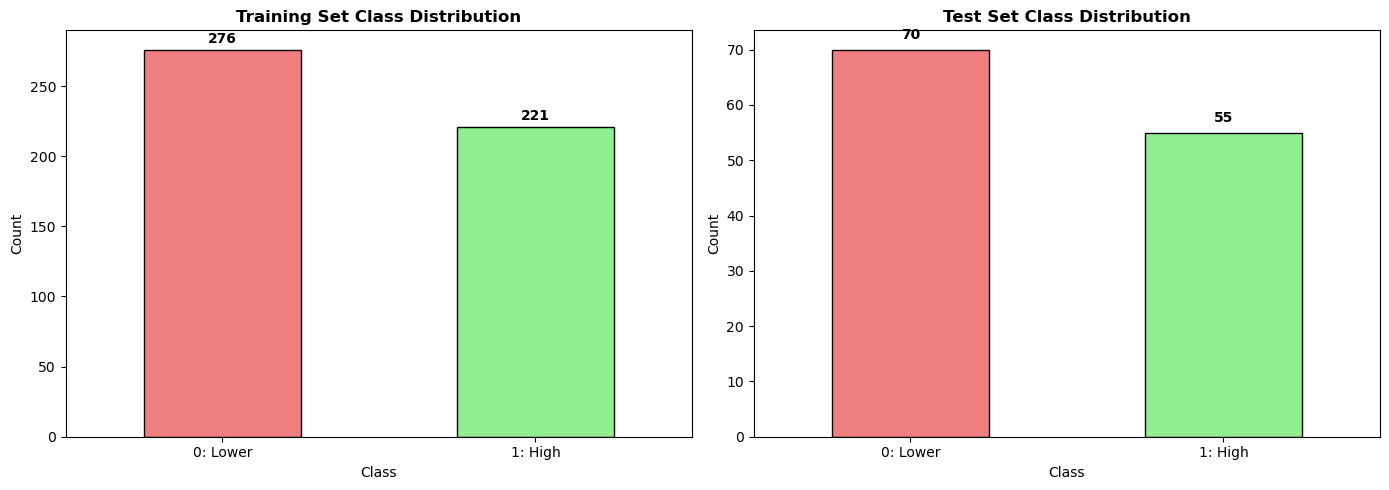

In [19]:
# Visualize train/test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], 
                                          color=['lightcoral', 'lightgreen'], 
                                          edgecolor='black')
axes[0].set_title('Training Set Class Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['0: Lower', '1: High'], rotation=0)
for i, v in enumerate(train_dist):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Test set
y_test.value_counts().sort_index().plot(kind='bar', ax=axes[1], 
                                         color=['lightcoral', 'lightgreen'], 
                                         edgecolor='black')
axes[1].set_title('Test Set Class Distribution', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['0: Lower', '1: High'], rotation=0)
for i, v in enumerate(test_dist):
    axes[1].text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"train_test_split_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\nSaved train/test split visualization to: {out_path}")

plt.show()

## Save Preprocessed Datasets

In [20]:
# Save train/test splits with all features
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_path = DATA_PROC / "student_performance_train.csv"
test_path = DATA_PROC / "student_performance_test.csv"

train_data.to_csv(train_path, index=False)
test_data.to_csv(test_path, index=False)

print(f"\nTraining data saved to: {train_path}")
print(f"Shape: {train_data.shape}")

print(f"\nTest data saved to: {test_path}")
print(f"Shape: {test_data.shape}")

# Save complete preprocessed dataset
df_preprocessed = pd.concat([X_scaled, y], axis=1)
preprocessed_path = DATA_PROC / "student_performance_preprocessed.csv"
df_preprocessed.to_csv(preprocessed_path, index=False)

print(f"\nFull preprocessed dataset saved to: {preprocessed_path}")
print(f"Shape: {df_preprocessed.shape}")

# Save feature names for later use
feature_names_path = DATA_PROC / "feature_names.txt"
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(X.columns))

print(f"\nFeature names saved to: {feature_names_path}")



Training data saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_train.csv
Shape: (497, 31)

Test data saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_test.csv
Shape: (125, 31)

Full preprocessed dataset saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_preprocessed.csv
Shape: (622, 31)

Feature names saved to: /Users/lia/Desktop/Fase1/data/processed/feature_names.txt


## Preprocessing Summary

In [21]:
print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")

print("\nDATASET TRANSFORMATION:")
print(f"Original shape: {df.shape}")
print(f"After removing duplicates: {df_clean.shape}")
print(f"After encoding: {df_encoded.shape}")
print(f"Final features: {X_scaled.shape[1]}")

print("\nTARGET VARIABLE:")
print(f"Original classes: 4 (Average, Good, Vg, Excellent)")
print(f"Binary classes: 2 (0: Lower, 1: High)")
print(f"Class 0: {y.value_counts()[0]} samples ({y.value_counts(normalize=True)[0]*100:.1f}%)")
print(f"Class 1: {y.value_counts()[1]} samples ({y.value_counts(normalize=True)[1]*100:.1f}%)")

print("\nFEATURE ENGINEERING:")
print(f"Grouped rare study time categories")
print(f"Ordinal encoding: 3 features")
print(f"One-hot encoding: 8 categorical variables")
print(f"StandardScaler: 3 ordinal features")
print(f"Total features: {X_scaled.shape[1]}")

print("\nTRAIN/TEST SPLIT:")
print(f"Training: {X_train.shape[0]} samples (80%)")
print(f"Testing: {X_test.shape[0]} samples (20%)")
print(f"Stratified: Yes")
print(f"Random state: 42")

print("\nFILES SAVED:")
print(f"1. {train_path.name} ({train_data.shape[0]} rows)")
print(f"2. {test_path.name} ({test_data.shape[0]} rows)")
print(f"3. {preprocessed_path.name} ({df_preprocessed.shape[0]} rows)")
print(f"4. {feature_names_path.name}")

print("\nDATA QUALITY:")
print(f"• No missing values")
print(f"• No duplicates")
print(f"• All features scaled appropriately")
print(f"• Class balance maintained in splits")

print("\nFEATURE BREAKDOWN:")
ordinal_count = len(ordinal_features)
binary_count = len(binary_features)
print(f"• Ordinal features (scaled): {ordinal_count}")
print(f"• Binary features (0/1): {binary_count}")
print(f"• Total features: {ordinal_count + binary_count}")


PREPROCESSING SUMMARY

DATASET TRANSFORMATION:
Original shape: (666, 12)
After removing duplicates: (622, 13)
After encoding: (622, 35)
Final features: 30

TARGET VARIABLE:
Original classes: 4 (Average, Good, Vg, Excellent)
Binary classes: 2 (0: Lower, 1: High)
Class 0: 346 samples (55.6%)
Class 1: 276 samples (44.4%)

FEATURE ENGINEERING:
Grouped rare study time categories
Ordinal encoding: 3 features
One-hot encoding: 8 categorical variables
StandardScaler: 3 ordinal features
Total features: 30

TRAIN/TEST SPLIT:
Training: 497 samples (80%)
Testing: 125 samples (20%)
Stratified: Yes
Random state: 42

FILES SAVED:
1. student_performance_train.csv (497 rows)
2. student_performance_test.csv (125 rows)
3. student_performance_preprocessed.csv (622 rows)
4. feature_names.txt

DATA QUALITY:
• No missing values
• No duplicates
• All features scaled appropriately
• Class balance maintained in splits

FEATURE BREAKDOWN:
• Ordinal features (scaled): 3
• Binary features (0/1): 27
• Total featur

## Data Verification

In [22]:
# Verify no data leakage
print("\nChecking for data leakage...")
train_indices = set(X_train.index)
test_indices = set(X_test.index)
overlap = train_indices.intersection(test_indices)
print(f"Overlapping indices between train and test: {len(overlap)}")
print("✓ No data leakage!" if len(overlap) == 0 else "⚠ WARNING: Data leakage detected!")

# Verify feature consistency
print("\nVerifying feature consistency...")
print(f"Training features: {X_train.shape[1]}")
print(f"Test features: {X_test.shape[1]}")
print("✓ Features match!" if X_train.shape[1] == X_test.shape[1] else "⚠ Feature mismatch!")

# Check for any remaining missing values
print("\nChecking for missing values...")
train_missing = train_data.isnull().sum().sum()
test_missing = test_data.isnull().sum().sum()
print(f"Training set missing values: {train_missing}")
print(f"Test set missing values: {test_missing}")
print("✓ No missing values!" if (train_missing == 0 and test_missing == 0) else "⚠ Missing values found!")


Checking for data leakage...
Overlapping indices between train and test: 0
✓ No data leakage!

Verifying feature consistency...
Training features: 30
Test features: 30
✓ Features match!

Checking for missing values...
Training set missing values: 0
Test set missing values: 0
✓ No missing values!
